In [1]:
import os

In [16]:
import albumentations as A

In [17]:
pwd

'/Users/phuongchi/Documents/GLEASON_2019/Full_Harvard_set'

In [125]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import collections
import time
import pandas as pd

In [19]:
import tensorflow as tf

In [20]:
print("Tensorflow version: ", tf.__version__)

Tensorflow version:  1.15.0


In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import *
%matplotlib inline
import random
# import re
# from PIL import Image
#from tensorflow.keras.engine import Layer
from tensorflow.keras.applications.vgg16 import *
from tensorflow.keras.models import *
#from tensorflow.keras.applications.imagenet_utils import _obtain_input_shape
import tensorflow.keras.backend as K
# import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Cropping2D, Conv2D
from tensorflow.keras.layers import Input, Add, Dropout, Permute, add
# from tensorflow.compat.v1.layers import conv2d_transpose
from tensorflow.layers import conv2d_transpose
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [26]:
DATA_DIR = '/Users/phuongchi/Documents/GLEASON_2019/Full_Harvard_set/DATASET'

In [27]:
x_train_dir = os.path.join(DATA_DIR, 'train_frames')
y_train_dir = os.path.join(DATA_DIR, 'train_masks')

x_valid_dir = os.path.join(DATA_DIR, 'val_frames')
y_valid_dir = os.path.join(DATA_DIR, 'val_masks')
                           

x_test_dir = os.path.join(DATA_DIR, 'test_frames')
y_test_dir_pathologist1 = os.path.join(DATA_DIR, 'test_masks_1')
y_test_dir_pathologist2 = os.path.join(DATA_DIR, 'test_masks_2')
                          

In [28]:
x_train_dir

'/Users/phuongchi/Documents/GLEASON_2019/Full_Harvard_set/DATASET/train_frames'

In [47]:
len(os.listdir(x_train_dir))

508

In [50]:
len(os.listdir(y_train_dir))

508

In [40]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

# Data Loading

0=Benign (green), 

1=Gleason_3 (blue), 

2=Gleason_4 (yellow),

3=Gleason_5 (red), 

4=unlabelled (white).

In [12]:
colormap = {0:(0, 255, 0), 
           1:(0, 0, 255), 
           2:(255, 255, 0), 
           3:(255, 0, 0),
           4:(255,255,255)
           }

In [51]:
# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
   
    
    def __init__(
            self, 
            images_dir, 
#             img_list,
            masks_dir,         
            colormap = colormap,  
            is_testset = False, # 'train' or 'test' or 'validation' 
            augmentation=None, 
            preprocessing=None,
            with_shape_assert= False
    ):
        self.image_ids = os.listdir(images_dir)
        self.is_testset = is_testset
        #self.image_ids = img_list
        self.mask_ids = os.listdir(masks_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.image_ids]
        
        
        self.masks_fps =[]
        for i in self.image_ids:
            for j in self.mask_ids:
                if self.is_testset == True:
                    if i[:-4] == j[6:-4]:
                        self.masks_fps.append(os.path.join(masks_dir,j))
                else:
                    if i[:-4] == j[5:-4]:
                        self.masks_fps.append(os.path.join(masks_dir,j))
        
        # convert str names to class values on masks
        #self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.with_shape_assert = with_shape_assert
        
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        
       
        num_classes = len(colormap)
        shape = mask.shape[:2]+(num_classes,)
        encoded_mask = np.zeros( shape, dtype=np.int8)
        for i, cls in enumerate(colormap):
            encoded_mask[:,:,i] = np.all(mask.reshape((-1,3) ) == colormap[i], axis=1).reshape(shape[:2])
        
        encoded_mask.astype('float')
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=encoded_mask)
            image, encoded_mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=encoded_mask)
            image, encoded_mask = sample['image'], sample['mask']
        
        #this is to check the shape of image and ask after the agumentation and preprprocessing
        if self.with_shape_assert:
            assert image.shape ==(512, 512, 3)
            assert encoded_mask.shape ==(512,512,5)
            
        return image, encoded_mask
        
    def __len__(self):
        return len(self.image_ids)
    
    def allItemsToStr(self):
        result = "imgs are " + str(len(self.image_ids)) + " masks " + str(len(self.mask_ids))
        # for each img, result + img path/ name.../ size
        return result
    
    def __str__(self):
        return 'Dataset: len is: ' + str(len(self.image_ids)) + " item summary: " + self.allItemsToStr() 
    
 

0=Benign (green),

1=Gleason_3 (blue),

2=Gleason_4 (yellow),

3=Gleason_5 (red),

4=unlabelled (white).

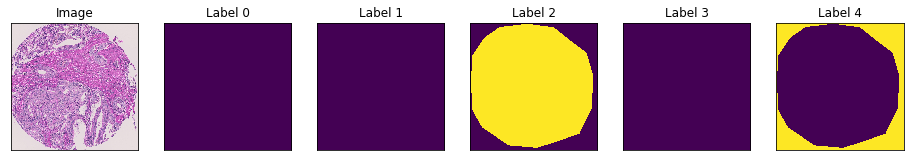

In [52]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir,colormap = colormap)
image,encoded_mask = dataset[0] # get some sample
visualize(
    image=image, 
    
    label_0=encoded_mask[..., 0].squeeze(),
    label_1=encoded_mask[..., 1].squeeze(),
    label_2=encoded_mask[..., 2].squeeze(),
    label_3=encoded_mask[..., 3].squeeze(),
    label_4=encoded_mask[..., 4].squeeze(),
    
)


In [53]:
print(dataset)

Dataset: len is: 508 item summary: imgs are 508 masks 508


In [54]:
print(str(image.shape))

(3100, 3100, 3)


In [80]:
# define heavy augmentations
def get_training_augmentation():
    train_transform = [
        
        A.Resize(height=512, width=512, interpolation=cv2.INTER_NEAREST),

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        #A.PadIfNeeded(min_height=512, min_width=512, always_apply=True, border_mode=0),
        A.RandomCrop(height=512, width=512, always_apply=True),

        #A.IAAAdditiveGaussianNoise(p=0.2),
        #A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                #A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                #A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        # A.OneOf(
        #     [
        #         A.IAASharpen(p=1),
        #         A.Blur(blur_limit=3, p=1),
        #         A.MotionBlur(blur_limit=3, p=1),
        #     ],
        #     p=0.9,
        # ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.Resize(height=512, width=512, interpolation=cv2.INTER_NEAREST),
        #A.PadIfNeeded(512, 512)
    ]
    return A.Compose(test_transform)


def get_preprocessing():
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=normalize),
    ]
    return A.Compose(_transform)

def normalize(img, max_pixel_value=255.0, **args ):
    return img/255.0

In [81]:
class Dataloader(tf.keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integer number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
        https://github.com/tensorflow/tensorflow/blob/v2.1.0/tensorflow/python/keras/utils/data_utils.py#L444-L454
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        # check batch shape
        assert len(batch)==2
        assert batch[0].shape ==(self.batch_size, 512, 512, 3)
        assert batch[1].shape ==(self.batch_size, 512, 512, 5)
        
        return batch[0], batch[1]
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)
    
    def dataToStr(self,data):
        return "img= " + str(data[0].shape) + " mask= " + str(data[1].shape)
    
    def allDataSetToStr(self):
        result = ''
        for data in self.dataset:
            result + ' ## ' + self.dataToStr(data)
        
        return result
    
    def __str__(self):
        return 'Data loader ' + str(len(self.indexes)) + " batch size " + str(self.batch_size) + " data set " + str(len(self.dataset)) + self.allDataSetToStr()
    


# Segmentation model training

In [82]:
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3

# batch_shape=(512,512,3)
# inputs = Input(batch_shape=(4, 512, 512, 3))
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
#s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(5, (1, 1), activation='softmax')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])


In [83]:
# define optomizer
optim = tf.keras.optimizers.Adam()

In [84]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())


def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)

In [ ]:
loss= tf.keras.losses.CategoricalCrossentropy()
MeanIoU = tf.keras.metrics.MeanIoU(num_classes=5)

In [86]:
#calculates dice considering an input with a single class
def dice_single(true,pred):
    true = K.flatten(true)
    pred = K.flatten(pred)
    pred = K.round(pred)

    intersection = K.sum(true * pred, axis=-1)
    true = K.sum(true, axis=-1)
    pred = K.sum(pred, axis=-1)

    return ((2*intersection) + K.epsilon()) / (true + pred + K.epsilon())

def dice_inner0(true,pred):
    #get only the desired class
    true = true[:,:,:,0]
    pred = pred[:,:,:,0]
    return dice_single(true,pred)

def dice_inner1(true,pred):
    #get only the desired class
    true = true[:,:,:,1]
    pred = pred[:,:,:,1]
    return dice_single(true,pred)

def dice_inner2(true,pred):
    #get only the desired class
    true = true[:,:,:,2]
    pred = pred[:,:,:,2]
    return dice_single(true,pred)

def dice_inner3(true,pred):
    #get only the desired class
    true = true[:,:,:,3]
    pred = pred[:,:,:,3]
    return dice_single(true,pred)

def dice_inner4(true,pred):
    #get only the desired class
    true = true[:,:,:,4]
    pred = pred[:,:,:,4]
    return dice_single(true,pred)

# def dice_inner5(true,pred):
#     #get only the desired class
#     true = true[:,:,:,5]
#     pred = pred[:,:,:,5]
#     return dice_single(true,pred)

In [87]:
#smooth = 1.

In [106]:
model.compile(optim, loss = loss , metrics=[dice_coef,dice_inner0,dice_inner1,dice_inner2,dice_inner3,dice_inner4,MeanIoU,'accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 512, 512, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 512, 512, 16) 0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 512, 512, 16) 2320        dropout_9[0][0]                  
____________________________________________________________________________________________

# SET UP DATA FOR TRAINING

In [107]:
BATCH_SIZE = 2
LR = 0.0001
EPOCHS = 10
n_classes = len(colormap)

In [108]:
n_classes

5

In [109]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(), 
    with_shape_assert= True
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(), 
    with_shape_assert= True
)

train_dataloader = Dataloader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloader(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 512, 512, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 512, 512, n_classes)

In [110]:
len(train_dataloader)

254

In [111]:
len(valid_dataloader)

133

In [92]:
train_dataset[0][0].shape

(512, 512, 3)

In [93]:
train_dataset[0][1].shape

(512, 512, 5)

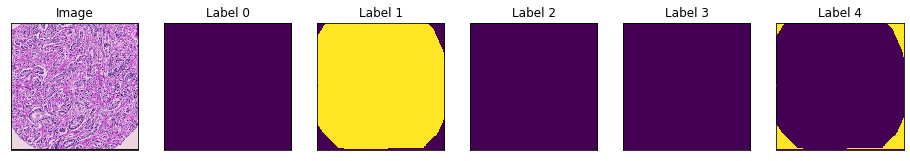

In [95]:
#visualize one pair of image and mask in the train_dataset

image, mask = train_dataset[1] # get some sample
visualize(
    image=image, 
    label_0=mask[..., 0].squeeze(),
    label_1=mask[..., 1].squeeze(),
    label_2=mask[..., 2].squeeze(),
    label_3=mask[..., 3].squeeze(),
    label_4=mask[..., 4].squeeze(),
    
)

In [112]:
tb = TensorBoard(log_dir='logs', write_graph=True)
mc = ModelCheckpoint(mode='min', filepath='MiniUNet_2809_best_Harvard.h5', monitor='loss', save_best_only=True, verbose=1)
es = EarlyStopping(mode='min', monitor='val_loss', patience=50, verbose=1)
callbacks = [tb, mc, es]

In [113]:
no_of_training_images = 508
no_of_validation_images = 133

start_time = time.time()
results_2809 = model.fit(
    train_dataloader,
    steps_per_epoch=len(train_dataloader),
    epochs=EPOCHS,
    validation_data=valid_dataloader,
    callbacks=callbacks,
    validation_steps=len(valid_dataloader),verbose=1)

end_time = time.time()
print(f"training duration: {end_time - start_time}")

#SAVE MODEL
model.save('MiniUNet_2809_Harvard.h5')

model.save_weights("MiniUNet_2809_Harvard_weights.h5", overwrite=True)

Epoch 1/10
133/254 [==============>...............] - ETA: 3:39 - loss: 1.4107 - dice_coef: 0.2682 - dice_inner0: 0.6842 - dice_inner1: 0.5263 - dice_inner2: 0.6842 - dice_inner3: 0.8797 - dice_inner4: 0.0187 - mean_io_u_1: 0.4000 - acc: 0.4815
Epoch 00001: loss improved from inf to 1.15273, saving model to MiniUNet_2809_best_Harvard.h5
254/254 [==============================] - 1439s 6s/step - loss: 1.1527 - dice_coef: 0.2307 - dice_inner0: 0.7087 - dice_inner1: 0.1353 - dice_inner2: 0.1693 - dice_inner3: 0.4646 - dice_inner4: 0.3213 - mean_io_u_1: 0.4222 - acc: 0.2906 - val_loss: 1.4107 - val_dice_coef: 0.2682 - val_dice_inner0: 0.6842 - val_dice_inner1: 0.5263 - val_dice_inner2: 0.6842 - val_dice_inner3: 0.8797 - val_dice_inner4: 0.0187 - val_mean_io_u_1: 0.4000 - val_acc: 0.4815
Epoch 2/10
133/254 [==============>...............] - ETA: 3:39 - loss: 1.1822 - dice_coef: 0.4061 - dice_inner0: 0.6842 - dice_inner1: 0.5489 - dice_inner2: 0.6842 - dice_inner3: 0.8797 - dice_inner4: 0.83

133/254 [==============>...............] - ETA: 3:22 - loss: 1.2528 - dice_coef: 0.3654 - dice_inner0: 0.6842 - dice_inner1: 0.5489 - dice_inner2: 0.6842 - dice_inner3: 0.8797 - dice_inner4: 0.8121 - mean_io_u_1: 0.4000 - acc: 0.4874
Epoch 00009: loss did not improve from 1.00859
254/254 [==============================] - 1260s 5s/step - loss: 1.0319 - dice_coef: 0.2833 - dice_inner0: 0.6933 - dice_inner1: 0.1496 - dice_inner2: 0.3307 - dice_inner3: 0.5866 - dice_inner4: 0.4090 - mean_io_u_1: 0.4230 - acc: 0.3097 - val_loss: 1.2528 - val_dice_coef: 0.3654 - val_dice_inner0: 0.6842 - val_dice_inner1: 0.5489 - val_dice_inner2: 0.6842 - val_dice_inner3: 0.8797 - val_dice_inner4: 0.8121 - val_mean_io_u_1: 0.4000 - val_acc: 0.4874
Epoch 10/10
133/254 [==============>...............] - ETA: 3:22 - loss: 1.1781 - dice_coef: 0.4489 - dice_inner0: 0.6842 - dice_inner1: 0.2932 - dice_inner2: 0.6842 - dice_inner3: 0.8797 - dice_inner4: 0.8532 - mean_io_u_1: 0.4000 - acc: 0.5063
Epoch 00010: loss 

# PLOT THE  HISTORY METRICS 

In [114]:
#-------------------------------------------------------------#

#EVALUATION
# Get actual number of epochs model was trained for
#Plot the model evaluation history for loss and accuracy
N = len(results_2809.history['loss'])
print(N)


10


10


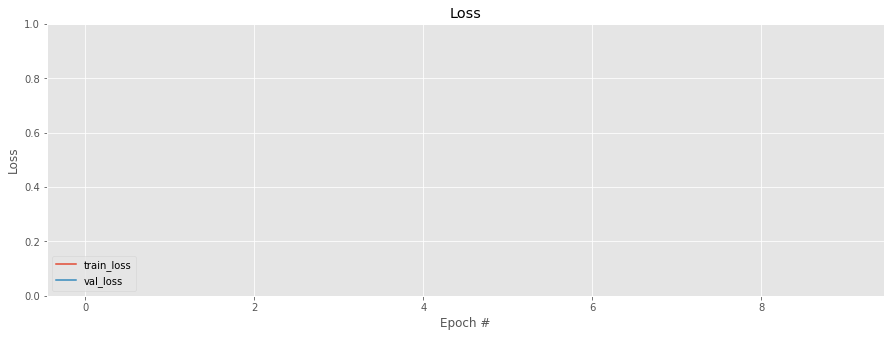

<Figure size 432x288 with 0 Axes>

In [122]:


plt.style.use("ggplot")
fig = plt.figure(figsize=(15,5))

plt.title("Loss")
plt.plot(np.arange(0, N), results_2809.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), results_2809.history["val_loss"], label="val_loss")
plt.ylim(0, 1)

plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()
plt.savefig('loss.png')
#-------------------------------------------------------------#


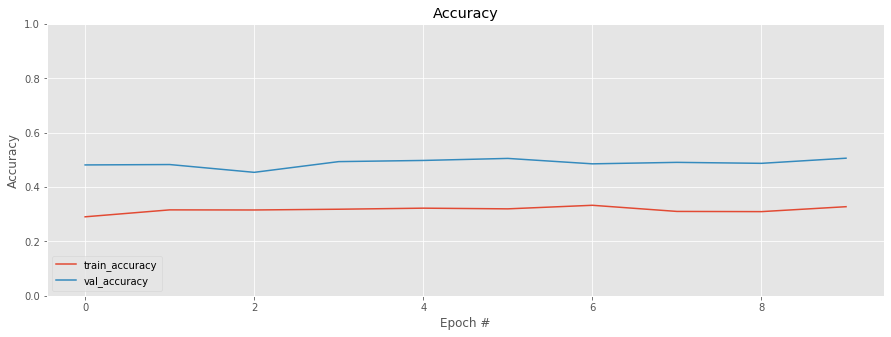

<Figure size 432x288 with 0 Axes>

In [116]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(15,5))

plt.title("Accuracy")
plt.plot(np.arange(0, N), results_2809.history["acc"], label="train_accuracy")
plt.plot(np.arange(0, N), results_2809.history["val_acc"], label="val_accuracy")
plt.ylim(0, 1)

plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.show()
plt.savefig('acc.png')

#-------------------------------------------------------------#


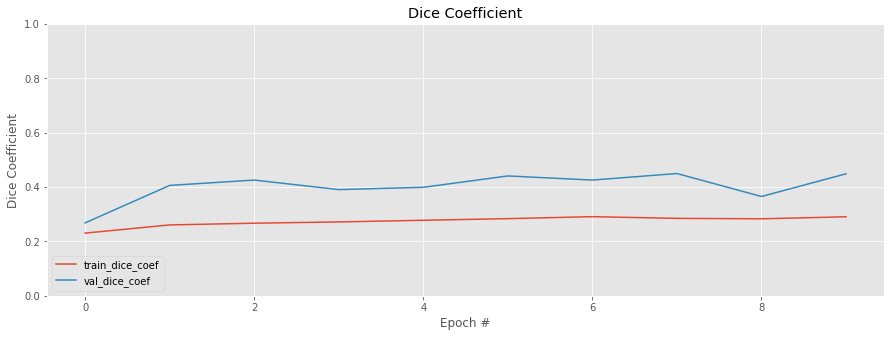

<Figure size 432x288 with 0 Axes>

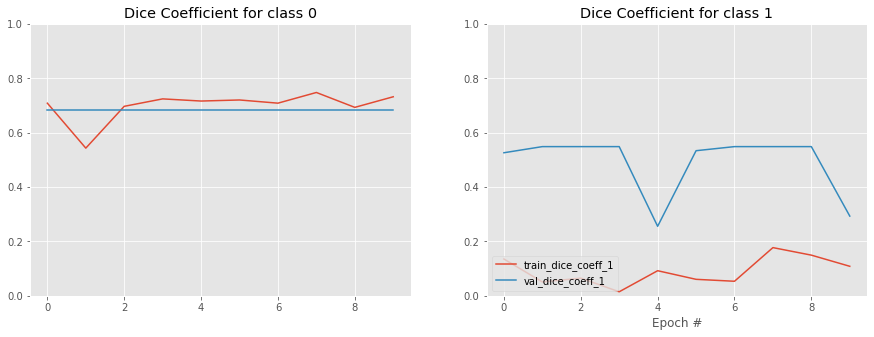

<Figure size 432x288 with 0 Axes>

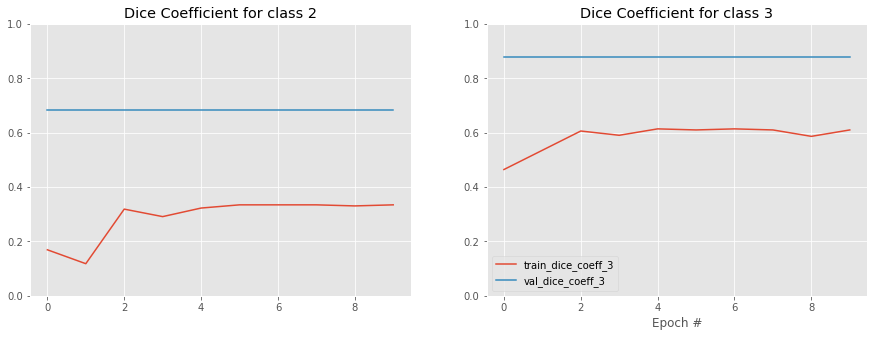

<Figure size 432x288 with 0 Axes>

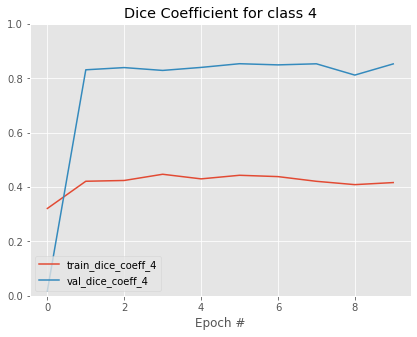

<Figure size 432x288 with 0 Axes>

In [128]:
#Plot the dice coefficient
plt.style.use("ggplot")
fig = plt.figure(figsize=(15,5))

plt.title("Dice Coefficient")
plt.plot(np.arange(0, N), results_2809.history["dice_coef"], label="train_dice_coef")
plt.plot(np.arange(0, N), results_2809.history["val_dice_coef"], label="val_dice_coef")
plt.ylim(0, 1)

plt.xlabel("Epoch #")
plt.ylabel("Dice Coefficient")
plt.legend(loc="lower left")
plt.show()
plt.savefig('dice_coeff.png')
#-------------------------------------------------------------#


#Plot the dice coefficient for each class

plt.style.use("ggplot")
fig = plt.figure(figsize=(15,5))

fig.add_subplot(1,2,1)
plt.title("Dice Coefficient for class 0")
plt.plot(np.arange(0, N), results_2809.history["dice_inner0"], label="train_dice_coeff_0")
plt.plot(np.arange(0, N), results_2809.history["val_dice_inner0"], label="val_dice_coeff_0")
plt.ylim(0, 1)

fig.add_subplot(1,2,2)
plt.title("Dice Coefficient for class 1")
plt.plot(np.arange(0, N), results_2809.history["dice_inner1"], label="train_dice_coeff_1")
plt.plot(np.arange(0, N), results_2809.history["val_dice_inner1"], label="val_dice_coeff_1")
plt.ylim(0, 1)

plt.xlabel("Epoch #")
#plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
plt.savefig('dice_coeff_0_1.png')
#-------------------------------------------------------------#
plt.style.use("ggplot")
fig = plt.figure(figsize=(15,5))

fig.add_subplot(1,2,1)
plt.title("Dice Coefficient for class 2")
plt.plot(np.arange(0, N), results_2809.history["dice_inner2"], label="train_dice_coeff_2")
plt.plot(np.arange(0, N), results_2809.history["val_dice_inner2"], label="val_dice_coeff_2")
plt.ylim(0, 1)

fig.add_subplot(1,2,2)
plt.title("Dice Coefficient for class 3")
plt.plot(np.arange(0, N), results_2809.history["dice_inner3"], label="train_dice_coeff_3")
plt.plot(np.arange(0, N), results_2809.history["val_dice_inner3"], label="val_dice_coeff_3")
plt.ylim(0, 1)

plt.xlabel("Epoch #")
#plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
plt.savefig('dice_coeff_2_3.png')

#-------------------------------------------------------------#

plt.style.use("ggplot")
fig = plt.figure(figsize=(15,5))

fig.add_subplot(1,2,1)
plt.title("Dice Coefficient for class 4")
plt.plot(np.arange(0, N), results_2809.history["dice_inner4"], label="train_dice_coeff_4")
plt.plot(np.arange(0, N), results_2809.history["val_dice_inner4"], label="val_dice_coeff_4")
plt.ylim(0, 1)

plt.xlabel("Epoch #")
#plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
plt.savefig('dice_coeff_4.png')


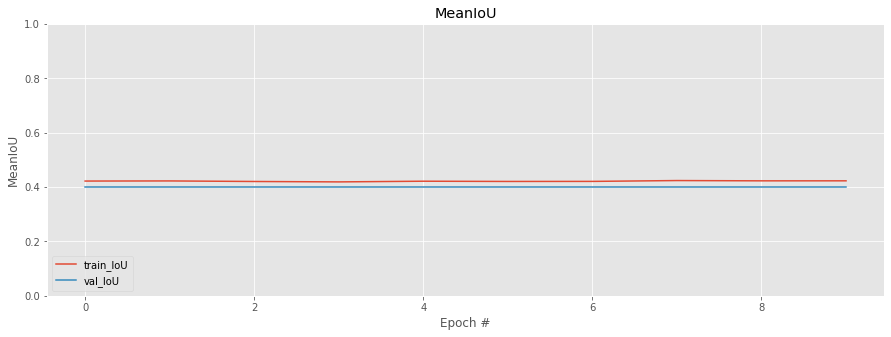

<Figure size 432x288 with 0 Axes>

In [124]:
#Plot the model evaluation history for meaniOu


plt.style.use("ggplot")
fig = plt.figure(figsize=(15,5))

plt.title("MeanIoU")
plt.plot(np.arange(0, N), results_2809.history["mean_io_u_1"], label="train_IoU")
plt.plot(np.arange(0, N), results_2809.history["val_mean_io_u_1"], label="val_IoU")
plt.ylim(0, 1)

plt.xlabel("Epoch #")
plt.ylabel("MeanIoU")
plt.legend(loc="lower left")
plt.show()
plt.savefig('MeanIoU.png')


In [127]:
#save history results to df

results_2809_df = pd.DataFrame(data=results_2809.history)

results_2809_df.to_csv('results_2809_Harvard_miniUnet.csv')
